# Forecasting air pollution with RNNs
### result    
1. Simple RNN
2. Simple LSTM
3. Stacked LSTM

## 0. Import Packages

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

## 1. Make Dataset

In [99]:
dataset = np.zeros((314,1))

for hour in range(24) :
    path = os.path.join(os.getcwd(), 'air_pollution_data', 'Hour_{}'.format(hour+1) + '.csv')
    csv = pd.read_csv(path, encoding = 'cp949', header = None)
    csv.head()
    data = csv.values[:,-1]
    data = data.reshape(314,1)
    
    dataset = np.concatenate((dataset, data), axis = 1)
    
dataset = dataset[:, 1:]    

In [81]:
# dataset = dataset.reshape(314,24)

In [85]:
# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(dataset)

In [100]:
dataset = dataset.reshape(314,1,24)
print("Shape of dataset :", dataset.shape)

Shape of dataset : (314, 1, 24)


In [101]:
x = dataset[:, :, :23]
y = dataset[:, :, -1]

In [102]:
print("Shape of x :", x.shape)
print("Shape of y :", y.shape)

Shape of x : (314, 1, 23)
Shape of y : (314, 1)


In [103]:
x_train = x[:251,:,:]
y_train = y[:251,:]

x_test = x[252:,:,:]
y_test = y[252:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(251, 1, 23) (251, 1)
(62, 1, 23) (62, 1)


## 2-1. Simple RNN

In [151]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(16, input_shape=(1,23)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

In [152]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
losses = tf.compat.v1.losses.log_loss
simple_rnn.compile(loss = root_mean_squared_error, optimizer='adam')    

In [153]:
simple_rnn_hist = simple_rnn.fit(x_train, y_train,
                       epochs = 100,
                       batch_size = 1,
                       verbose = 1, 
                       validation_split=0.2)

Train on 200 samples, validate on 51 samples
Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 70.5200 - val_loss: 77.0214
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 65.8499 - val_loss: 72.9061
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 62.2454 - val_loss: 69.6286
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 59.2304 - val_loss: 66.5276
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 56.7415 - val_loss: 63.6868
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 54.6213 - val_loss: 61.1090
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 52.4296 - val_loss: 58.4576
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 50.2999 - val_loss: 55.8413
Epoch 9/100
200/200 [==============================] - 0s 2ms/step - loss: 48.3397 - val_loss: 53.2039
Epoch 10/100
200/200 [======

## 2-2. Results

In [154]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

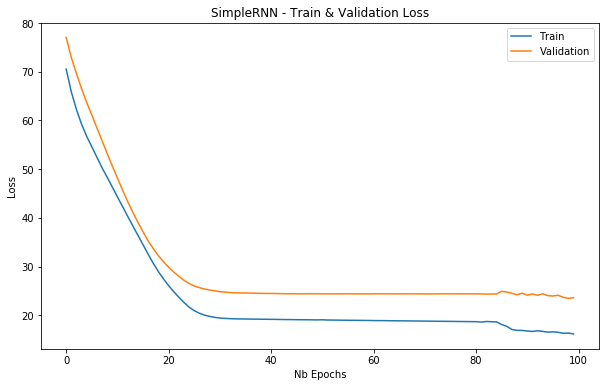

Minimum validation loss of 23.492153392118567 reached at epoch 98


In [155]:
plot_loss(simple_rnn_hist, 'SimpleRNN - Train & Validation Loss')

In [156]:
train_pred = simple_rnn.predict(x_train)
test_pred = simple_rnn.predict(x_test)

train_RMSE = mean_squared_error(y_train, train_pred) ** 0.5
test_RMSE = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE :', train_RMSE)
print('Test RMSE :', test_RMSE)

Train RMSE : 23.23517998710388
Test RMSE : 37.71782444725679


In [157]:
yy = simple_rnn.predict(x)
result = mean_squared_error(y, yy) ** 0.5
print("RMSE of 314 dataset :", result)

RMSE of 314 dataset : 26.69200521340075


In [348]:
# save model architecture
model_json = simple_rnn.to_json()
open('simple_rnn_with_100iterations.json', 'w').write(model_json)

# save model's learned weights
simple_rnn.save_weights('simple_rnn_weights_with_100iterations.h5', overwrite=True)

## 3-1. Simple LSTM

In [318]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(16, input_shape=(1, 23)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())
simple_lstm.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 16)                2560      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 17        
Total params: 2,577
Trainable params: 2,577
Non-trainable params: 0
_________________________________________________________________


In [322]:
simple_lstm_hist = simple_lstm.fit(x_train, y_train,
                       epochs = 100,
                       batch_size = 1,
                       verbose = 1, 
                       validation_split=0.2)

Train on 200 samples, validate on 51 samples
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 70.1325 - val_loss: 78.4084
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 68.6292 - val_loss: 77.0527
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 67.3144 - val_loss: 75.8008
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 65.9646 - val_loss: 74.4792
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 64.4322 - val_loss: 72.6344
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 62.8594 - val_loss: 71.2313
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 61.5452 - val_loss: 69.8840
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 60.2941 - val_loss: 68.5651
Epoch 9/100
200/200 [==============================] - 0s 2ms/step - loss: 59.1479 - val_loss: 67.3315
Epoch 10/100
200/200 [======

## 3-2. Results

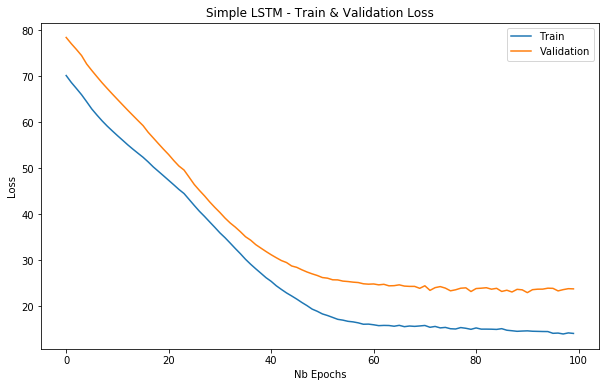

Minimum validation loss of 22.942065295051126 reached at epoch 90


In [323]:
plot_loss(simple_lstm_hist, 'Simple LSTM - Train & Validation Loss')

In [324]:
train_pred = simple_lstm.predict(x_train)
test_pred = simple_lstm.predict(x_test)

train_RMSE = mean_squared_error(y_train, train_pred) ** 0.5
test_RMSE = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE :', train_RMSE)
print('Test RMSE :', test_RMSE)

Train RMSE : 21.2162573860298
Test RMSE : 38.52582741978493


In [325]:
yy = simple_lstm.predict(x)
result = mean_squared_error(y, yy) ** 0.5
print("RMSE of 314 dataset :", result)

RMSE of 314 dataset : 25.551617402133502


In [349]:
# save model architecture
model_json = simple_lstm.to_json()
open('simple_lstm_with_100iterations.json', 'w').write(model_json)

# save model's learned weights
simple_lstm.save_weights('simple_lstm_weights_with_100iterations.h5', overwrite=True)

## 4-1. Stacked LSTM model

In [344]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(256, input_shape=(1, 23), return_sequences=True))
# stacked_lstm.add(Dropout(0.3))

stacked_lstm.add(LSTM(256, return_sequences=True))
# stacked_lstm.add(Dropout(0.3))

stacked_lstm.add(LSTM(256))
# stacked_lstm.add(Dropout(0.3))

stacked_lstm.add(Dense(32, activation = "relu"))

stacked_lstm.add(Dense(1))
stacked_lstm.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_108 (LSTM)              (None, 1, 256)            286720    
_________________________________________________________________
lstm_109 (LSTM)              (None, 1, 256)            525312    
_________________________________________________________________
lstm_110 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dense_68 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 33        
Total params: 1,345,601
Trainable params: 1,345,601
Non-trainable params: 0
_________________________________________________________________


In [345]:
losses = tf.compat.v1.losses.log_loss
stacked_lstm.compile(loss = root_mean_squared_error, optimizer='adam')

In [346]:
stacked_lstm_hist = stacked_lstm.fit(x_train, y_train,
                       epochs = 1000,
                       batch_size = 256,
                       verbose = 1, 
                       validation_split=0.2)

Train on 200 samples, validate on 51 samples
Epoch 1/1000
200/200 [==============================] - 2s 8ms/step - loss: 76.9983 - val_loss: 85.1208
Epoch 2/1000
200/200 [==============================] - 0s 330us/step - loss: 76.9387 - val_loss: 85.0522
Epoch 3/1000
200/200 [==============================] - 0s 323us/step - loss: 76.8684 - val_loss: 84.9526
Epoch 4/1000
200/200 [==============================] - 0s 325us/step - loss: 76.7678 - val_loss: 84.8055
Epoch 5/1000
200/200 [==============================] - 0s 335us/step - loss: 76.6223 - val_loss: 84.5951
Epoch 6/1000
200/200 [==============================] - 0s 325us/step - loss: 76.4166 - val_loss: 84.3014
Epoch 7/1000
200/200 [==============================] - 0s 320us/step - loss: 76.1325 - val_loss: 83.9003
Epoch 8/1000
200/200 [==============================] - 0s 393us/step - loss: 75.7487 - val_loss: 83.3676
Epoch 9/1000
200/200 [==============================] - 0s 495us/step - loss: 75.2415 - val_loss: 82.6838
Epo

Epoch 78/1000
200/200 [==============================] - 0s 365us/step - loss: 22.2529 - val_loss: 28.3672
Epoch 79/1000
200/200 [==============================] - 0s 330us/step - loss: 19.2675 - val_loss: 28.1834
Epoch 80/1000
200/200 [==============================] - 0s 325us/step - loss: 19.6758 - val_loss: 28.0308
Epoch 81/1000
200/200 [==============================] - 0s 360us/step - loss: 20.3257 - val_loss: 28.0978
Epoch 82/1000
200/200 [==============================] - 0s 345us/step - loss: 20.0792 - val_loss: 28.0561
Epoch 83/1000
200/200 [==============================] - 0s 355us/step - loss: 19.3121 - val_loss: 27.9906
Epoch 84/1000
200/200 [==============================] - 0s 390us/step - loss: 18.6311 - val_loss: 27.9449
Epoch 85/1000
200/200 [==============================] - 0s 385us/step - loss: 18.3014 - val_loss: 27.8753
Epoch 86/1000
200/200 [==============================] - 0s 380us/step - loss: 18.0159 - val_loss: 27.7240
Epoch 87/1000
200/200 [==============

Epoch 155/1000
200/200 [==============================] - 0s 405us/step - loss: 8.1142 - val_loss: 18.9429
Epoch 156/1000
200/200 [==============================] - 0s 340us/step - loss: 8.3118 - val_loss: 17.4265
Epoch 157/1000
200/200 [==============================] - 0s 355us/step - loss: 7.9852 - val_loss: 17.8114
Epoch 158/1000
200/200 [==============================] - 0s 350us/step - loss: 7.1602 - val_loss: 18.6989
Epoch 159/1000
200/200 [==============================] - 0s 380us/step - loss: 7.5434 - val_loss: 17.2201
Epoch 160/1000
200/200 [==============================] - 0s 375us/step - loss: 8.3147 - val_loss: 17.6636
Epoch 161/1000
200/200 [==============================] - 0s 355us/step - loss: 6.9100 - val_loss: 19.1213
Epoch 162/1000
200/200 [==============================] - 0s 325us/step - loss: 7.4244 - val_loss: 17.4790
Epoch 163/1000
200/200 [==============================] - 0s 325us/step - loss: 8.3860 - val_loss: 17.7921
Epoch 164/1000
200/200 [=============

Epoch 232/1000
200/200 [==============================] - 0s 350us/step - loss: 4.9029 - val_loss: 18.1720
Epoch 233/1000
200/200 [==============================] - 0s 340us/step - loss: 4.2700 - val_loss: 21.6723
Epoch 234/1000
200/200 [==============================] - 0s 355us/step - loss: 7.0549 - val_loss: 18.3257
Epoch 235/1000
200/200 [==============================] - 0s 325us/step - loss: 4.1116 - val_loss: 17.9955
Epoch 236/1000
200/200 [==============================] - 0s 345us/step - loss: 4.8982 - val_loss: 19.8993
Epoch 237/1000
200/200 [==============================] - 0s 390us/step - loss: 5.5010 - val_loss: 18.2802
Epoch 238/1000
200/200 [==============================] - 0s 345us/step - loss: 3.8601 - val_loss: 18.0206
Epoch 239/1000
200/200 [==============================] - 0s 340us/step - loss: 4.4649 - val_loss: 19.8502
Epoch 240/1000
200/200 [==============================] - 0s 340us/step - loss: 4.8163 - val_loss: 18.2233
Epoch 241/1000
200/200 [=============

Epoch 309/1000
200/200 [==============================] - 0s 390us/step - loss: 2.8155 - val_loss: 19.3082
Epoch 310/1000
200/200 [==============================] - 0s 385us/step - loss: 2.5195 - val_loss: 20.5695
Epoch 311/1000
200/200 [==============================] - 0s 370us/step - loss: 2.9396 - val_loss: 18.8162
Epoch 312/1000
200/200 [==============================] - 0s 325us/step - loss: 3.8527 - val_loss: 20.3567
Epoch 313/1000
200/200 [==============================] - 0s 325us/step - loss: 2.5718 - val_loss: 19.4349
Epoch 314/1000
200/200 [==============================] - 0s 350us/step - loss: 2.2173 - val_loss: 20.1103
Epoch 315/1000
200/200 [==============================] - 0s 340us/step - loss: 2.3629 - val_loss: 19.0878
Epoch 316/1000
200/200 [==============================] - 0s 335us/step - loss: 3.3330 - val_loss: 21.3943
Epoch 317/1000
200/200 [==============================] - 0s 320us/step - loss: 3.5753 - val_loss: 19.2496
Epoch 318/1000
200/200 [=============

Epoch 386/1000
200/200 [==============================] - 0s 320us/step - loss: 3.6396 - val_loss: 20.3408
Epoch 387/1000
200/200 [==============================] - 0s 330us/step - loss: 5.0199 - val_loss: 19.6696
Epoch 388/1000
200/200 [==============================] - 0s 335us/step - loss: 4.1274 - val_loss: 18.2804
Epoch 389/1000
200/200 [==============================] - 0s 340us/step - loss: 3.7043 - val_loss: 17.9758
Epoch 390/1000
200/200 [==============================] - 0s 350us/step - loss: 4.4182 - val_loss: 18.2645
Epoch 391/1000
200/200 [==============================] - 0s 335us/step - loss: 3.1944 - val_loss: 19.6669
Epoch 392/1000
200/200 [==============================] - 0s 330us/step - loss: 4.0318 - val_loss: 19.3400
Epoch 393/1000
200/200 [==============================] - 0s 330us/step - loss: 3.5535 - val_loss: 17.9203
Epoch 394/1000
200/200 [==============================] - 0s 320us/step - loss: 3.2652 - val_loss: 17.8936
Epoch 395/1000
200/200 [=============

Epoch 463/1000
200/200 [==============================] - 0s 325us/step - loss: 4.4295 - val_loss: 19.8231
Epoch 464/1000
200/200 [==============================] - 0s 320us/step - loss: 1.8353 - val_loss: 20.7597
Epoch 465/1000
200/200 [==============================] - 0s 320us/step - loss: 3.2320 - val_loss: 19.0097
Epoch 466/1000
200/200 [==============================] - 0s 308us/step - loss: 2.0468 - val_loss: 18.9690
Epoch 467/1000
200/200 [==============================] - 0s 335us/step - loss: 2.0897 - val_loss: 20.5241
Epoch 468/1000
200/200 [==============================] - 0s 330us/step - loss: 2.8677 - val_loss: 19.5314
Epoch 469/1000
200/200 [==============================] - 0s 345us/step - loss: 1.7416 - val_loss: 18.6811
Epoch 470/1000
200/200 [==============================] - 0s 330us/step - loss: 2.8648 - val_loss: 19.6378
Epoch 471/1000
200/200 [==============================] - 0s 325us/step - loss: 1.8022 - val_loss: 20.0316
Epoch 472/1000
200/200 [=============

Epoch 540/1000
200/200 [==============================] - 0s 310us/step - loss: 1.7258 - val_loss: 20.3439
Epoch 541/1000
200/200 [==============================] - 0s 325us/step - loss: 2.1680 - val_loss: 19.4218
Epoch 542/1000
200/200 [==============================] - 0s 335us/step - loss: 1.7237 - val_loss: 19.9245
Epoch 543/1000
200/200 [==============================] - 0s 325us/step - loss: 1.4321 - val_loss: 19.8076
Epoch 544/1000
200/200 [==============================] - 0s 370us/step - loss: 1.3590 - val_loss: 20.0639
Epoch 545/1000
200/200 [==============================] - 0s 345us/step - loss: 1.3365 - val_loss: 19.8762
Epoch 546/1000
200/200 [==============================] - 0s 330us/step - loss: 1.4019 - val_loss: 20.7466
Epoch 547/1000
200/200 [==============================] - 0s 325us/step - loss: 1.9860 - val_loss: 19.6233
Epoch 548/1000
200/200 [==============================] - 0s 325us/step - loss: 2.4597 - val_loss: 20.5246
Epoch 549/1000
200/200 [=============

Epoch 617/1000
200/200 [==============================] - 0s 350us/step - loss: 5.0614 - val_loss: 19.6363
Epoch 618/1000
200/200 [==============================] - 0s 310us/step - loss: 2.5002 - val_loss: 18.2504
Epoch 619/1000
200/200 [==============================] - 0s 325us/step - loss: 4.3160 - val_loss: 18.3358
Epoch 620/1000
200/200 [==============================] - 0s 315us/step - loss: 5.4606 - val_loss: 18.3347
Epoch 621/1000
200/200 [==============================] - 0s 330us/step - loss: 2.9385 - val_loss: 20.5607
Epoch 622/1000
200/200 [==============================] - 0s 325us/step - loss: 4.1182 - val_loss: 21.4246
Epoch 623/1000
200/200 [==============================] - 0s 325us/step - loss: 5.4167 - val_loss: 19.6930
Epoch 624/1000
200/200 [==============================] - 0s 320us/step - loss: 2.6291 - val_loss: 18.1906
Epoch 625/1000
200/200 [==============================] - 0s 340us/step - loss: 4.4000 - val_loss: 18.3093
Epoch 626/1000
200/200 [=============

Epoch 694/1000
200/200 [==============================] - 0s 330us/step - loss: 3.4841 - val_loss: 21.0603
Epoch 695/1000
200/200 [==============================] - 0s 325us/step - loss: 4.7230 - val_loss: 19.6040
Epoch 696/1000
200/200 [==============================] - 0s 335us/step - loss: 2.3864 - val_loss: 18.2704
Epoch 697/1000
200/200 [==============================] - 0s 310us/step - loss: 3.8528 - val_loss: 18.3004
Epoch 698/1000
200/200 [==============================] - 0s 315us/step - loss: 4.9748 - val_loss: 18.3658
Epoch 699/1000
200/200 [==============================] - 0s 320us/step - loss: 2.8147 - val_loss: 20.2931
Epoch 700/1000
200/200 [==============================] - 0s 310us/step - loss: 3.4905 - val_loss: 21.0607
Epoch 701/1000
200/200 [==============================] - 0s 335us/step - loss: 4.6772 - val_loss: 19.6164
Epoch 702/1000
200/200 [==============================] - 0s 310us/step - loss: 2.3295 - val_loss: 18.2948
Epoch 703/1000
200/200 [=============

Epoch 771/1000
200/200 [==============================] - 0s 335us/step - loss: 2.6266 - val_loss: 20.0731
Epoch 772/1000
200/200 [==============================] - 0s 325us/step - loss: 3.3058 - val_loss: 20.7903
Epoch 773/1000
200/200 [==============================] - 0s 325us/step - loss: 4.4332 - val_loss: 19.4301
Epoch 774/1000
200/200 [==============================] - 0s 335us/step - loss: 2.2267 - val_loss: 18.1575
Epoch 775/1000
200/200 [==============================] - 0s 320us/step - loss: 3.6195 - val_loss: 18.1749
Epoch 776/1000
200/200 [==============================] - 0s 325us/step - loss: 4.6807 - val_loss: 18.2687
Epoch 777/1000
200/200 [==============================] - 0s 325us/step - loss: 2.6538 - val_loss: 20.0876
Epoch 778/1000
200/200 [==============================] - 0s 350us/step - loss: 3.2459 - val_loss: 20.8015
Epoch 779/1000
200/200 [==============================] - 0s 330us/step - loss: 4.3796 - val_loss: 19.4422
Epoch 780/1000
200/200 [=============

Epoch 848/1000
200/200 [==============================] - 0s 355us/step - loss: 4.4456 - val_loss: 18.4386
Epoch 849/1000
200/200 [==============================] - 0s 380us/step - loss: 2.5030 - val_loss: 20.1741
Epoch 850/1000
200/200 [==============================] - 0s 370us/step - loss: 3.1022 - val_loss: 20.8517
Epoch 851/1000
200/200 [==============================] - 0s 355us/step - loss: 4.1854 - val_loss: 19.5719
Epoch 852/1000
200/200 [==============================] - 0s 315us/step - loss: 2.1043 - val_loss: 18.3401
Epoch 853/1000
200/200 [==============================] - 0s 330us/step - loss: 3.4173 - val_loss: 18.3400
Epoch 854/1000
200/200 [==============================] - 0s 320us/step - loss: 4.4244 - val_loss: 18.4447
Epoch 855/1000
200/200 [==============================] - 0s 325us/step - loss: 2.4852 - val_loss: 20.1660
Epoch 856/1000
200/200 [==============================] - 0s 320us/step - loss: 3.0993 - val_loss: 20.8368
Epoch 857/1000
200/200 [=============

Epoch 925/1000
200/200 [==============================] - 0s 315us/step - loss: 3.2706 - val_loss: 18.3728
Epoch 926/1000
200/200 [==============================] - 0s 310us/step - loss: 4.2531 - val_loss: 18.4848
Epoch 927/1000
200/200 [==============================] - 0s 320us/step - loss: 2.3868 - val_loss: 20.1274
Epoch 928/1000
200/200 [==============================] - 0s 325us/step - loss: 2.9549 - val_loss: 20.7756
Epoch 929/1000
200/200 [==============================] - 0s 335us/step - loss: 4.0065 - val_loss: 19.5582
Epoch 930/1000
200/200 [==============================] - 0s 332us/step - loss: 2.0181 - val_loss: 18.3429
Epoch 931/1000
200/200 [==============================] - 0s 315us/step - loss: 3.2508 - val_loss: 18.3229
Epoch 932/1000
200/200 [==============================] - 0s 320us/step - loss: 4.2353 - val_loss: 18.4359
Epoch 933/1000
200/200 [==============================] - 0s 315us/step - loss: 2.3766 - val_loss: 20.0942
Epoch 934/1000
200/200 [=============

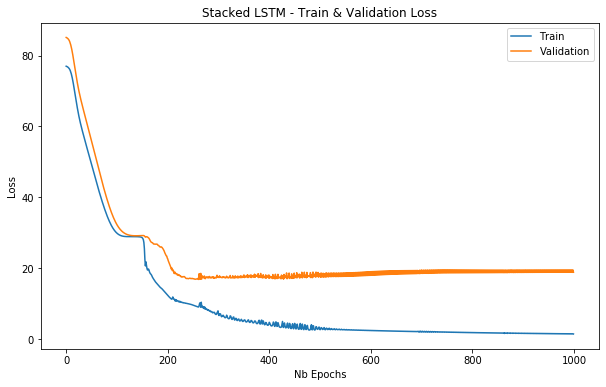

Minimum validation loss of 16.806177139282227 reached at epoch 261


In [341]:
plot_loss(stacked_lstm_hist, 'Stacked LSTM - Train & Validation Loss')

In [342]:
train_pred = stacked_lstm.predict(x_train)
test_pred = stacked_lstm.predict(x_test)

train_RMSE = mean_squared_error(y_train, train_pred) ** 0.5
test_RMSE = mean_squared_error(y_test, test_pred) ** 0.5

print('Train RMSE :', train_RMSE)
print('Test RMSE :', test_RMSE)

Train RMSE : 8.59560309521233
Test RMSE : 21.391073451674053


In [343]:
yy = stacked_lstm.predict(x)
result = mean_squared_error(y, yy) ** 0.5
print("RMSE of 314 dataset :", result)

RMSE of 314 dataset : 12.29860038254354


In [350]:
# save model architecture
model_json = stacked_lstm.to_json()
open('stacked_lstm_with_100iterations.json', 'w').write(model_json)

# save model's learned weights
stacked_lstm.save_weights('stacked_lstm_weights_with_100iterations.h5', overwrite=True)

## 5. Visualization

In [351]:
prediction = yy
# interpolation

(314, 1)